# MountainCar

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from collections import deque
import numpy as np
import random
from tqdm import tqdm  # shows where we are through training
import matplotlib.pyplot as plt   # to show off results
from IPython.display import clear_output

C:\Users\carno\anaconda3\envs\rl_fixer\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\carno\anaconda3\envs\rl_fixer\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\carno\anaconda3\envs\rl_fixer\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\carno\anaconda3\envs\rl_fixer\lib\site-packages\tensorf

MountainCar gives the position and velocity in the range $\left[ -1.2, 0.6 \right] \times\left[ -0.07, 0.07 \right]$.

In [2]:
env_name = "MountainCar-v0"
env = gym.make(env_name)

gamma = 0.99 # discount factor (want it high because we only care about the end)
learning_rate = 0.001  # learning rate
batch_size = 32   # how many experiences to train on at once
memory_length = 30000

state_size = env.observation_space.shape[0]   # state dimension
action_size = env.action_space.n   # 0, 1, or 2

num_trials = 1250
test_freq = 25   # after how many trials do we want to look at results?
num_tests = 3    # how many tests in each test
extra_tests = 1000   # at the end, how many additional tests do we want to do that are not rendered?

epsilon = 1  # start by moving randomly
epsilon_min = .02  # minimum epsilon
epsilon_episodes = int(num_trials/2)  # after this many episodes, have epsilon_min

In [3]:
def create_DQN():

    DQN = models.Sequential()

    DQN.add(layers.Dense(24, activation='relu', input_shape=env.observation_space.shape))
    DQN.add(layers.Dense(48, activation='relu'))
    DQN.add(layers.Dense(24, activation='relu'))
    DQN.add(layers.Dense(env.action_space.n, activation = 'linear'))

    adam = optimizers.Adam(lr=learning_rate)

    DQN.compile(loss=losses.mse, optimizer=adam, metrics=['accuracy']);
    
    return DQN

DQN = create_DQN()
DQN.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1200      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 75        
Total params: 2,523
Trainable params: 2,523
Non-trainable params: 0
_________________________________________________________________


In [4]:
class Memory():
  def __init__(self, env, max_size=memory_length, amount_filled=1):
    self.mem = deque(maxlen = max_size)   # deques are nice
    step = 0
    while step < int(memory_length*amount_filled):   # only fill to approximately half (by default)
        s = env.reset()
        done = False
        while not done:
            a = env.action_space.sample()
            s1, r, done, info = env.step(a)
            self.remember([s,a,r,s1,done])
            s = s1
            step += 1
    env.close()
  
  
  def remember(self, experience):   # SARS'd: [state, action, reward, new_state, done]
    self.mem.append(experience)
  
  
  # return a list of useable indices (assumes batch_size < len(self.mem))
  def sample(self, batch_size=batch_size):
    indices = random.sample(range(len(self.mem)), batch_size)   # pick random indices based on the length of the deque
    batch = []
    for i in indices:
      batch.append(self.mem[i])   # put the actually memories into a list
    return batch

memory = Memory(env, memory_length)

In [5]:
# Train our neural network
def train(DQN):
    batch = memory.sample()
    s_mb = np.array([each[0].reshape(env.observation_space.shape[0],) for each in batch])
#     s_mb = s_mb.reshape(batch_size, env.observation_space.shape[0]) #######################################################
    a_mb = np.array([each[1] for each in batch])
    r_mb = np.array([each[2] for each in batch])
    s1_mb = np.array([each[3].reshape(env.observation_space.shape[0],) for each in batch])
#     s1_mb = s1_mb.reshape(batch_size, env.observation_space.shape[0]) #######################################################
    done_mb = np.array([each[4] for each in batch])
    
    # Get future Q values
    Qs1 = DQN.predict(s1_mb)
    targets_mb = DQN.predict(s_mb)
    for i in range(len(batch)):     # r if done, r+gamma*Q(s') else
        terminal = done_mb[i]
        a = a_mb[i]

        if terminal:
          target = r_mb[i]
        else:
          target = r_mb[i] + gamma*np.max(Qs1[i])

        targets_mb[i][a] = target
    targets_mb = np.array(targets_mb)

    
    hist = DQN.fit(s_mb, targets_mb, epochs=1, verbose=False, batch_size = batch_size)
    loss = hist.history['loss'][0]

    return loss


# A function to select an action based on the current Q table and epsilon

def select_action(state, eps):
    if np.random.rand() < eps:   # chance we pick a random action
        return np.random.randint(action_size)
    Qs = DQN.predict(state.reshape(1,state_size))
    return np.argmax(Qs)



# Test current Q_table

def tester(env):
    super_total = 0
    for _ in range(num_tests):
        done = False
        total = 0
        s = env.reset()
        while not done:
            a = select_action(s, 0)   # epsilon = 0 means always choose best action
            s, r, done, _ = env.step(a)
            total += r
        super_total += total
    return super_total/num_tests   # return average total score
    


# Efficiently computes moving averages

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [6]:
# Housekeeping stuff
env = gym.make(env_name)   # create environment
epsilon_decay = (epsilon-epsilon_min)/epsilon_episodes # how quickly epsilon decays


# For Visualization of Results
rewards_list = []
max_pos_list = []
loss_list = []
test_rewards = []

In [7]:
# Train
for episode in tqdm(range(num_trials)):
    score = 0
    s = env.reset()
    done = False
    step = 0
    max_pos = -2
    while not done:
#         clear_output(wait=True)
#         print(step)
        a = select_action(s, epsilon)
        s1, r, done, _ = env.step(a)
        max_pos = min(max(s1[0], max_pos),0.5)
        memory.remember([s,a,r,s1,done])

        score += r
        if step % 1 == 0:
            loss = train(DQN)
            loss_list.append(loss)

        if done:
            epsilon -= epsilon_decay
            max_pos_list.append(max_pos)
            break

        s = s1
        step += 1

    rewards_list.append(score)
    
    if episode % test_freq == 0:
        test_rewards.append(tester(env))

env.close()

100%|████████████████████████████████████████████████████████████████████| 1250/1250 [38:06<00:00,  1.83s/it]


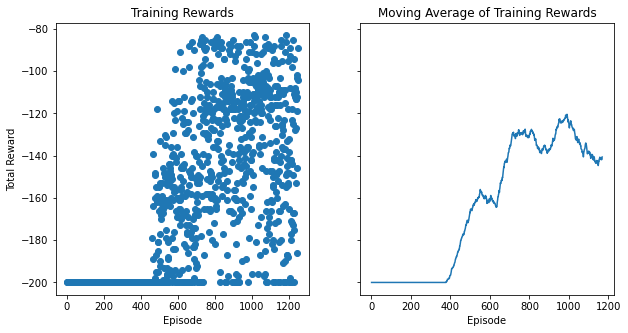

In [8]:
moving_average_len = int(np.floor(len(rewards_list)/15))
moving_average = running_mean(rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Training Rewards')
ax1.scatter([i+1 for i in range(len(rewards_list))], rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

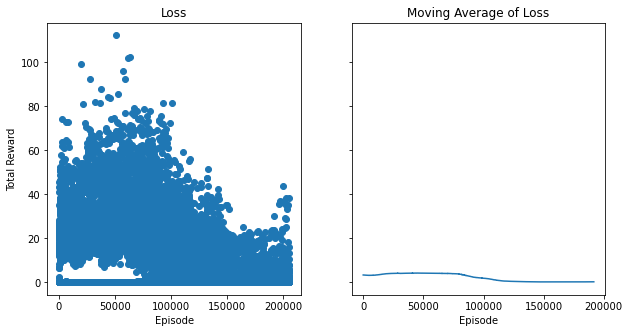

In [9]:
moving_average_len = int(np.floor(len(loss_list)/15))
moving_average = running_mean(loss_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Loss')
ax1.scatter([i+1 for i in range(len(loss_list))], loss_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Loss')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

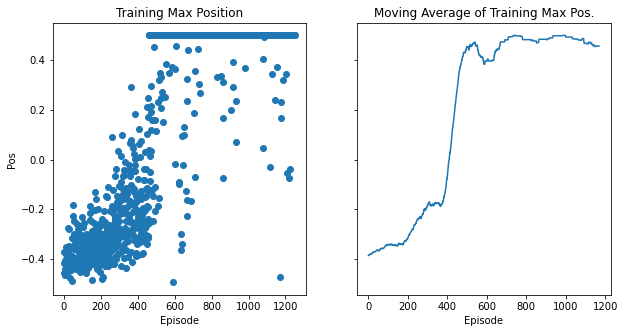

In [10]:
moving_average_len = int(np.floor(len(max_pos_list)/15))
moving_average = running_mean(max_pos_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Training Max Position')
ax1.scatter([i+1 for i in range(len(max_pos_list))], max_pos_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Pos')


ax2.set_title('Moving Average of Training Max Pos.')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

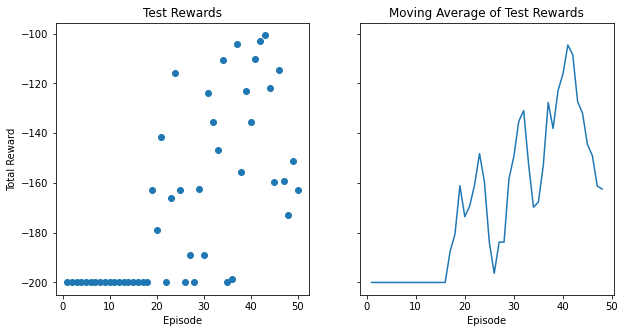

In [11]:
moving_average_len = int(np.floor(len(test_rewards)/15))
moving_average = running_mean(test_rewards, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Test Rewards')
ax1.scatter([i+1 for i in range(len(test_rewards))], test_rewards)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Test Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

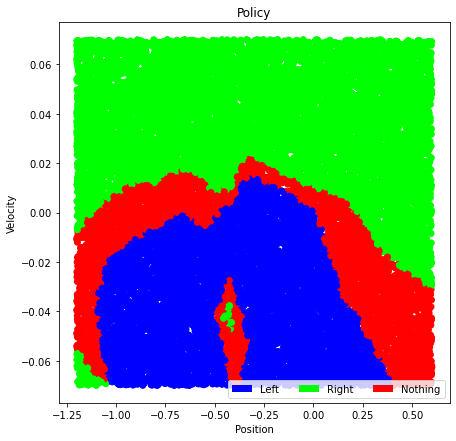

In [12]:
import pandas as pd
X = np.random.uniform(-1.2, 0.6, 20000)
Y = np.random.uniform(-0.07, 0.07, 20000)
Z = []
for i in range(len(X)):
    state = np.array([X[i], Y[i]])
    Z.append(select_action(state, 0))   # select action
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,len(colors.unique())):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

In [13]:
super_total = 0
for _ in range(extra_tests):
    done = False
    total = 0
    s = env.reset()
    while not done:
        a = select_action(s, 0)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        total += r
    super_total += total
for _ in range(num_tests):
    done = False
    total = 0
    s = env.reset()
    env.render()
    while not done:
        a = select_action(s, 0)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        env.render()
        total += r
    super_total += total
print("Average Reward: {}".format(round(super_total/(num_tests+extra_tests), 5)))   # return average total score
env.close()

Average Reward: -155.42273


# Modifed MountainCar

In [14]:
# Housekeeping stuff
env = gym.make(env_name)   # create environment
epsilon_decay = (epsilon-epsilon_min)/epsilon_episodes # how quickly epsilon decays

memory = Memory(env, memory_length) # Remake memory
DQN = create_DQN()   # remake DQN


# For Visualization of Results
rewards_list = []
max_pos_list = []
test_rewards = []
loss_list = []
true_rewards_list = []

In [15]:
# Train
for episode in tqdm(range(num_trials//2)):
    score = 0
    true_score = 0
    s = env.reset()
    done = False
    max_pos = -2
    step = 0
    while not done:
        a = select_action(s, epsilon)
        s1, r, done, _ = env.step(a)
        max_pos = min(max(s1[0], max_pos),0.5)
        
        true_score += r
        r += min(s1[0], 0.5)/25
        
        memory.remember([s,a,r,s1,done])

        score += r
        if step % 1 == 0:
            loss = train(DQN)
            loss_list.append(loss)

        if done:
            epsilon -= epsilon_decay
            max_pos_list.append(max_pos)
            break

        s = s1

    rewards_list.append(score)
    true_rewards_list.append(true_score)
    
    step += 1
    
    if episode % test_freq == 0:
        test_rewards.append(tester(env))

env.close()

100%|██████████████████████████████████████████████████████████████████████| 625/625 [11:59<00:00,  1.15s/it]


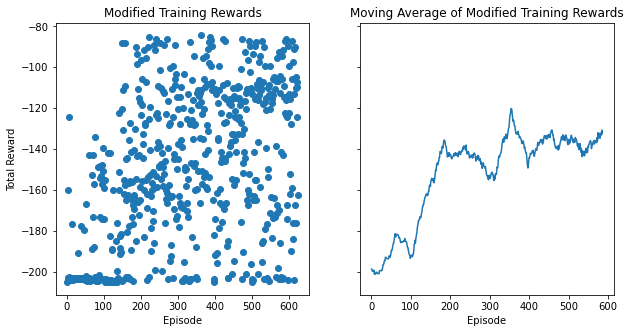

In [16]:
moving_average_len = int(np.floor(len(rewards_list)/15))
moving_average = running_mean(rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Modified Training Rewards')
ax1.scatter([i+1 for i in range(len(rewards_list))], rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Modified Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

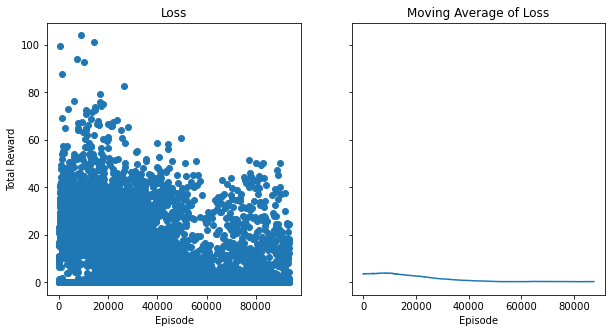

In [17]:
moving_average_len = int(np.floor(len(loss_list)/15))
moving_average = running_mean(loss_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Loss')
ax1.scatter([i+1 for i in range(len(loss_list))], loss_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Loss')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

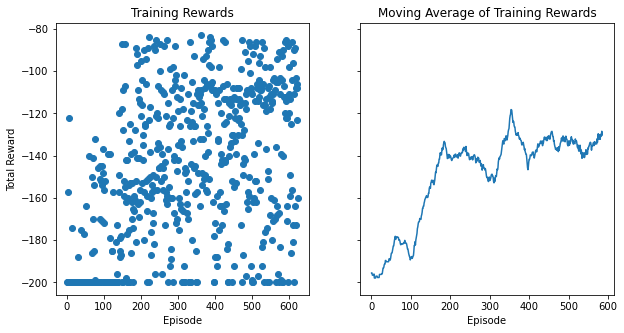

In [18]:
moving_average_len = int(np.floor(len(true_rewards_list)/15))
moving_average = running_mean(true_rewards_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Training Rewards')
ax1.scatter([i+1 for i in range(len(true_rewards_list))], true_rewards_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Training Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

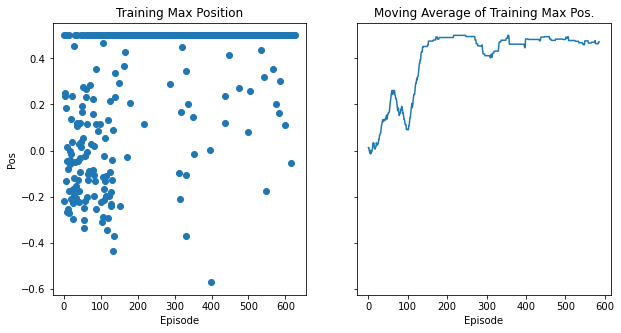

In [19]:
moving_average_len = int(np.floor(len(max_pos_list)/15))
moving_average = running_mean(max_pos_list, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Training Max Position')
ax1.scatter([i+1 for i in range(len(max_pos_list))], max_pos_list)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Pos')


ax2.set_title('Moving Average of Training Max Pos.')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

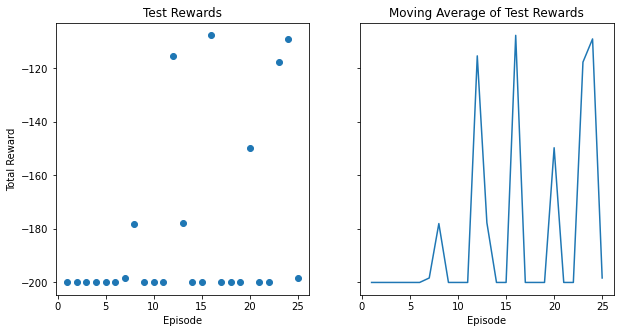

In [20]:
moving_average_len = int(np.floor(len(test_rewards)/15))
moving_average = running_mean(test_rewards, moving_average_len)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax1.set_title('Test Rewards')
ax1.scatter([i+1 for i in range(len(test_rewards))], test_rewards)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')

ax2.set_title('Moving Average of Test Rewards')
ax2.plot([i+1 for i in range(len(moving_average))], moving_average)
ax2.set_xlabel('Episode');

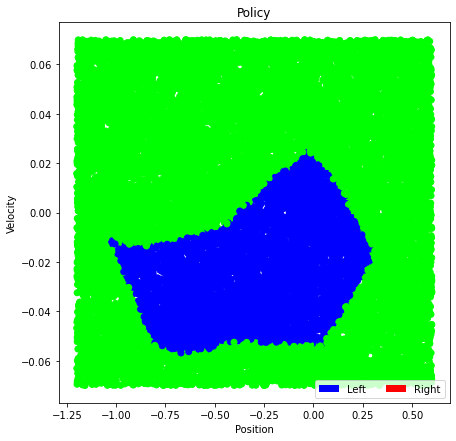

In [21]:
import pandas as pd
X = np.random.uniform(-1.2, 0.6, 20000)
Y = np.random.uniform(-0.07, 0.07, 20000)
Z = []
for i in range(len(X)):
    state = np.array([X[i], Y[i]])
    Z.append(select_action(state, 0))   # select action
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,len(colors.unique())):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

In [22]:
super_total = 0
for _ in range(extra_tests):
    done = False
    total = 0
    s = env.reset()
    while not done:
        a = select_action(s, 0)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        total += r
    super_total += total
for _ in range(num_tests):
    done = False
    total = 0
    s = env.reset()
    env.render()
    while not done:
        a = select_action(s, 0)   # epsilon = 0 means always choose best action
        s, r, done, _ = env.step(a)
        env.render()
        total += r
    super_total += total
print("Average Reward: {}".format(round(super_total/(num_tests+extra_tests), 5)))   # return average total score
env.close()

Average Reward: -109.3659
